In [112]:
import pickle
import argparse
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import glob

from main import main

## Run Iterated Learning Base Experiments

In [113]:
seeds = [1, 2, 3, 4, 5]

#train size split experiments (testing the impact of the size of the transmission set on language)
for t in ['0.3', '0.4', '0.5', '0.6', '0.7']:
    for s in seeds:
        main(['--seed', str(s), '--iterations', '1000', '--generations', '200', '--train-size', t, '--resume', '--hidden-size', '256'])

# Repeat experiment with GRU model instead of LSTM
for t in ['0.3', '0.4', '0.5', '0.6', '0.7']:
    for s in seeds:
        main(['--seed', str(s), '--iterations', '1000', '--generations', '200', '--train-size', t, '--resume', '--hidden-size', '256', '--model-type', 'gru'])

Meaning Space Length: 162
Meaning Space Length: 162
Meaning Space Length: 162
Meaning Space Length: 162
Meaning Space Length: 162
Meaning Space Length: 162
Meaning Space Length: 162
Meaning Space Length: 162
Meaning Space Length: 162
Meaning Space Length: 162
Meaning Space Length: 162
Meaning Space Length: 162
Meaning Space Length: 162
Meaning Space Length: 162
Meaning Space Length: 162
Meaning Space Length: 162
Meaning Space Length: 162
Meaning Space Length: 162
Meaning Space Length: 162
Meaning Space Length: 162
Meaning Space Length: 162
Meaning Space Length: 162
Meaning Space Length: 162
Meaning Space Length: 162
Meaning Space Length: 162
Meaning Space Length: 162
Meaning Space Length: 162
Meaning Space Length: 162
Meaning Space Length: 162
Meaning Space Length: 162
Meaning Space Length: 162
Meaning Space Length: 162
Meaning Space Length: 162
Meaning Space Length: 162
Meaning Space Length: 162
Meaning Space Length: 162
Meaning Space Length: 162
Meaning Space Length: 162
Meaning Spac

# Get Metrics from Runs

In [114]:
def get_run_name(n):
    m = n.split('_')[0]
    s = n.split('_')[-1]
    return m+'_'+s
    
# Loading metrics from saved pickles
metrics = {}
for m in glob.glob("runs/*/*/metrics.pkl"):
    run = m.split('/')[1]
    run_name = get_run_name(run)
    if run_name not in metrics:
        metrics[run_name] = {}
    seed = m.split('/')[2]
    metrics[run_name][seed] = pickle.load(open(m, 'rb'))

In [115]:
list(metrics.keys())

['gru_0.5',
 'gru_0.3',
 'gru_0.4',
 'lstm_0.7',
 'lstm_0.6',
 'gru_0.6',
 'gru_0.7',
 'lstm_0.4',
 'lstm_0.3',
 'lstm_0.5']

# *Updates from previous version*

- Added model GRU vs LSTM comparaison
- Added cross-seed RSA

Previously
- Calculate RSA metrics between hidden and message and hidden and input.
- Calculate cross generational RSA between messages and between hiddens. 


# Plot Results

In [116]:
def plot_metric(results, metric="test_loss", ylabel=None, show_error=True, 
                savefig=True, figname=None, title=None, ylim=None, a4_dims=(11.7, 8.27)):
    
    ci = 'sd' if show_error else None
    fig, ax = plt.subplots(figsize=a4_dims)
    
    generations = []
    values = []
    run_names = []
    
    for r in list(results.keys()):
        for s in list(results[r].keys()):    
            for g in sorted(list(results[r][s].keys())):
                generations.append(g)
                values.append(results[r][s][g][metric])
                run_names.append(r)
            
    values = np.array(values)
    iterations = np.array(generations)   
      
    d = {'Generations': iterations,'': run_names, metric: values}
    ax = sns.lineplot(ax=ax, x='Generations', y=metric, data=pd.DataFrame(data=d),
                      style='', hue='', 
                      palette=sns.color_palette("Set1", len(list(results.keys()))), ci=ci)
    if title is None:
        title = metric.replace('_', ' ').title()
    ax.set_title(title, fontsize=30)
    plt.show()

# LSTM Plot Train Split Results

Here we plot the experiments run when changing the size of the transmission set (train split) in relation to the entire meaning space. Plotted are the 0.1 intervals between 0.3 and 0.7, where a train split of 0.3 represents the case where only 30% of total meaning space is shown during training. 

In [117]:
def get_train_size_keys(a):
    keys = []
    for k in a:
        attributes = k.split('_')
        if attributes[0] == 'lstm':
            keys.append(k)
    return keys

train_size_dict = { k: metrics[k] for k in get_train_size_keys(list(metrics.keys()))}

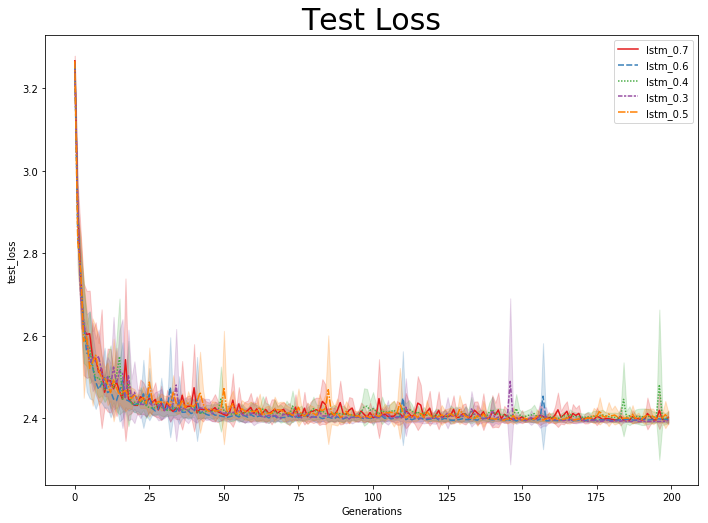

In [72]:
plot_metric(train_size_dict)

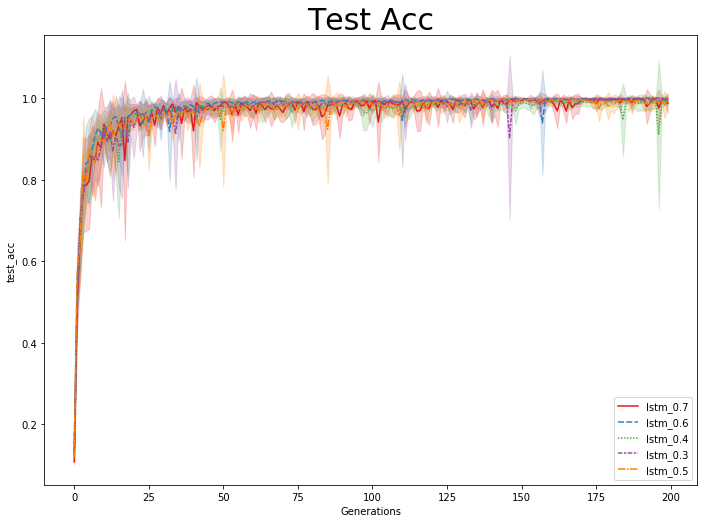

In [73]:
plot_metric(train_size_dict, metric='test_acc')

## RSA Metrics

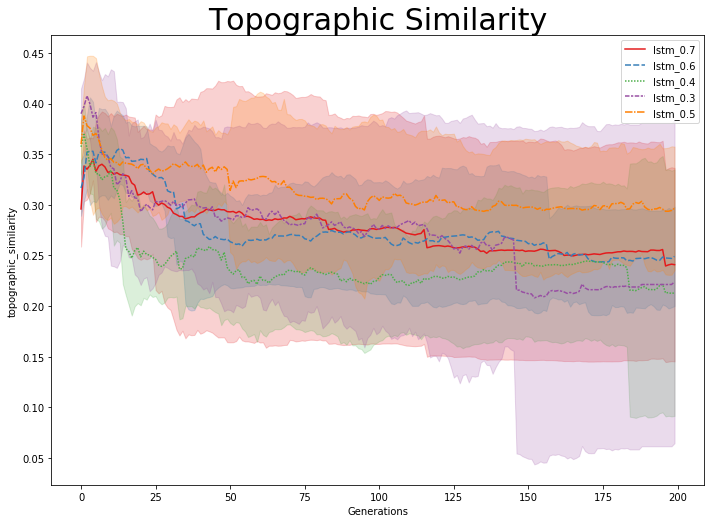

In [74]:
plot_metric(train_size_dict, metric='topographic_similarity') #hamming / hamming

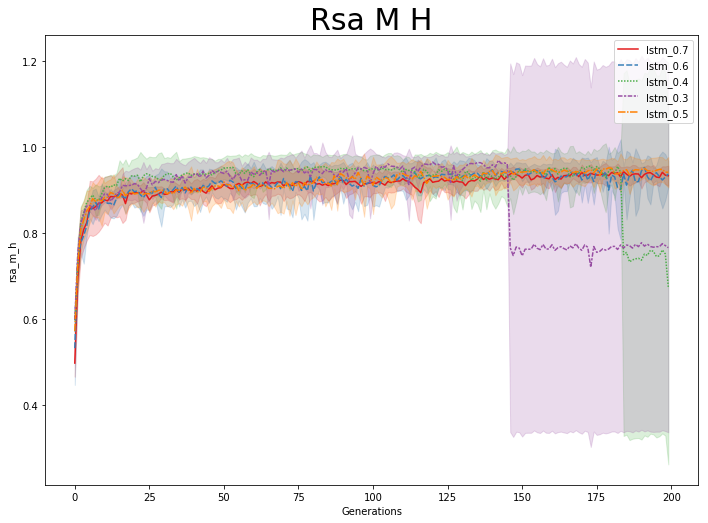

In [75]:
plot_metric(train_size_dict, metric='rsa_m_h') # hamming / cosine

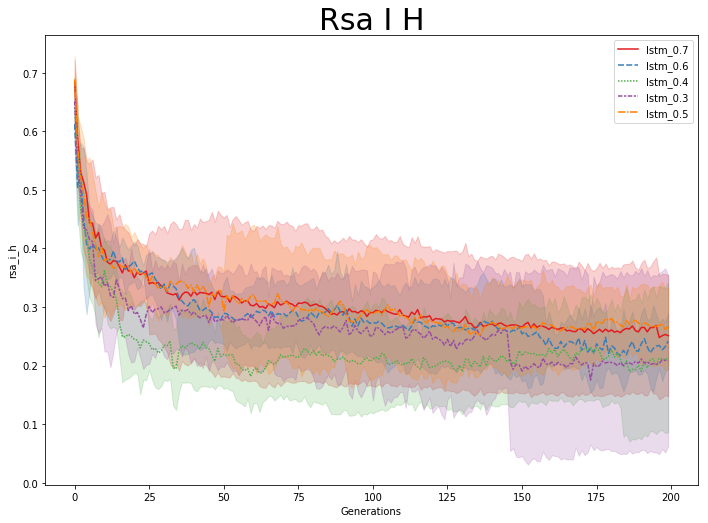

In [76]:
plot_metric(train_size_dict, metric='rsa_i_h') # hamming / cosine

# Cross Generational RSA

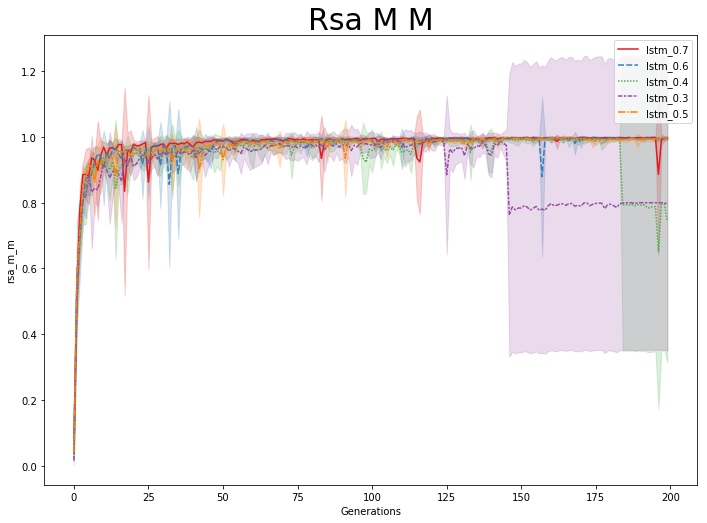

In [77]:
# Cross generational message RSA
plot_metric(train_size_dict, metric='rsa_m_m')  # hamming / hamming

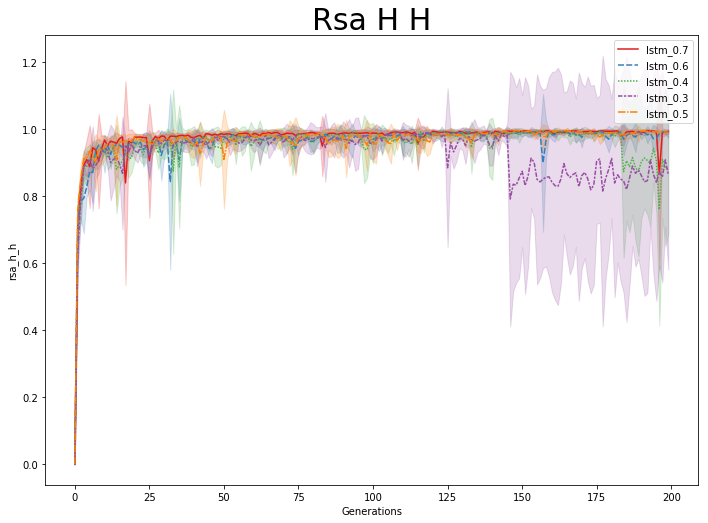

In [78]:
# Cross generational hidden states RSA
plot_metric(train_size_dict, metric='rsa_h_h')  # cosine / cosine

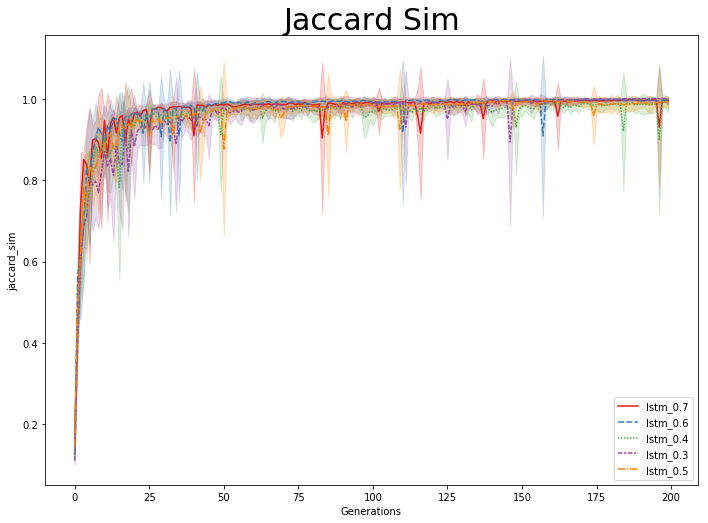

In [79]:
plot_metric(train_size_dict, metric='jaccard_sim')

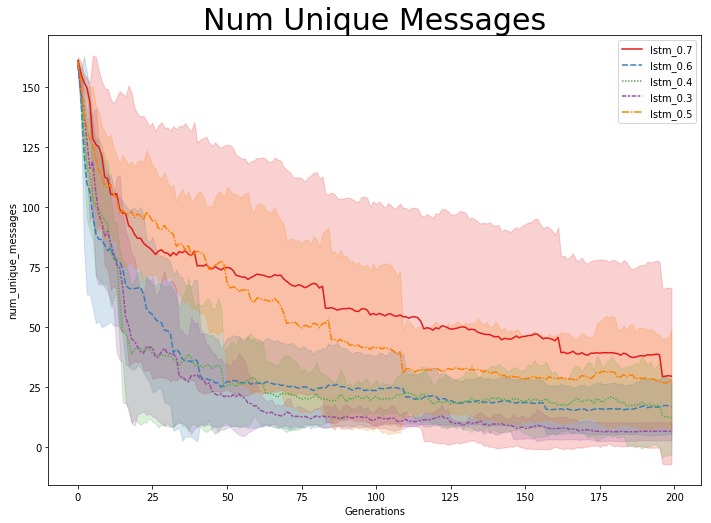

In [80]:
plot_metric(train_size_dict, metric='num_unique_messages')

From these we can conclude that the smaller the transmission set in relation to the original meaning space the less the models will take the input into account.

# Cross Seed Results

In [99]:
import itertools
import scipy.stats
import numpy as np

def get_correlation(folder_pair, filename:str):
    X = np.load(folder_pair[0]+filename)
    Y = np.load(folder_pair[1]+filename)
    if X.std() == 0 or Y.std() == 0:
        corr = 0
    else:
        corr = scipy.stats.pearsonr(X, Y)[0]
    return corr


cross_seed_metrics = {}
possible_runs = glob.glob("runs/*/")
for r in possible_runs:
    run_name = get_run_name(r.split('/')[1])
    cross_seed_metrics[run_name] = {}
    possible_seeds = glob.glob(r+'*')
    combinations = list(itertools.combinations(possible_seeds, 2))
    for p in combinations:
        seed_combination = p[0].split('/')[-1]+p[1].split('/')[-1]
        cross_seed_metrics[run_name][seed_combination] = {}
        for i in range(200):
            cross_seed_metrics[run_name][seed_combination][i] = {}
            hidden_filename = '/hidden_states_at_'+str(i)+'_sim.npy'
            language_filename = '/language_at_'+str(i)+'_sim.npy'
            rsa_h_h = get_correlation(p, hidden_filename)
            rsa_m_m = get_correlation(p, language_filename)

            cross_seed_metrics[run_name][seed_combination][i]['rsa_h_h'] = rsa_h_h
            cross_seed_metrics[run_name][seed_combination][i]['rsa_m_m'] = rsa_m_m

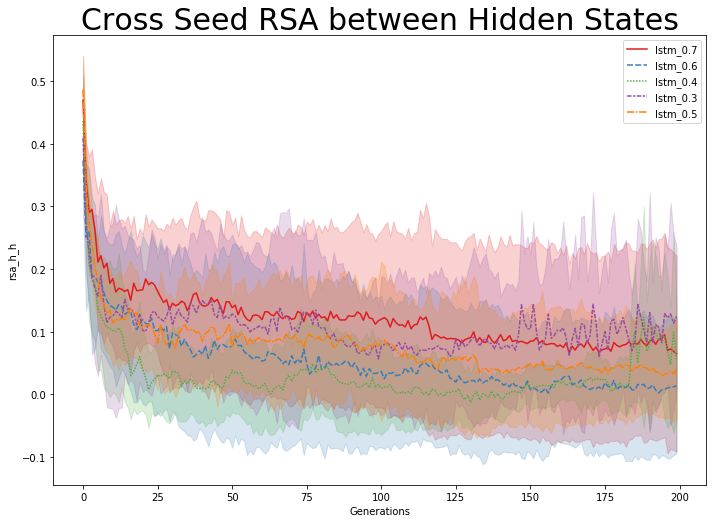

In [107]:
plot_metric(cross_seed_metrics, metric='rsa_h_h', title='Cross Seed RSA between Hidden States')

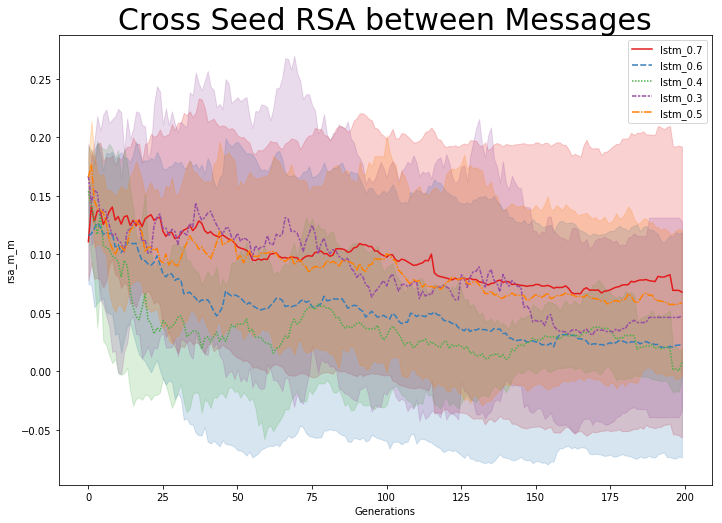

In [106]:
plot_metric(cross_seed_metrics, metric='rsa_m_m', title='Cross Seed RSA between Messages')

# Comparing Architectures: GRU vs LSTM

In [121]:
def get_arch_keys(a):
    keys = []
    for k in a:
        attributes = k.split('_')
        if attributes[1] == '0.7':
            keys.append(k)
    return keys

arch_dict = { k: metrics[k] for k in get_arch_keys(list(metrics.keys()))}


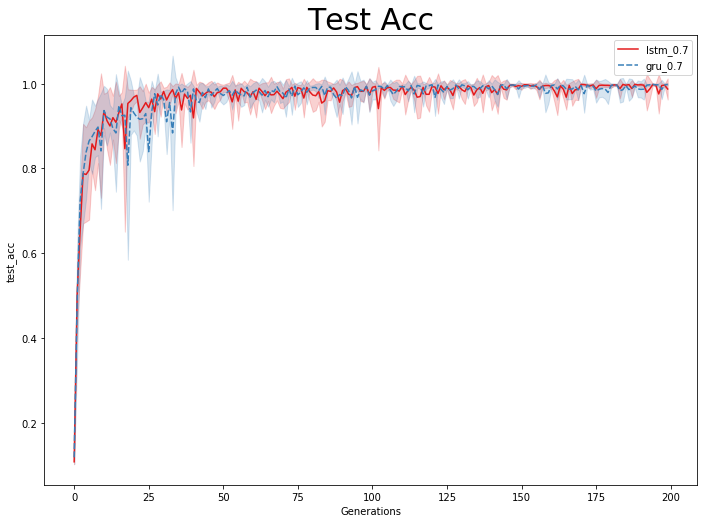

In [122]:
plot_metric(arch_dict, metric='test_acc')

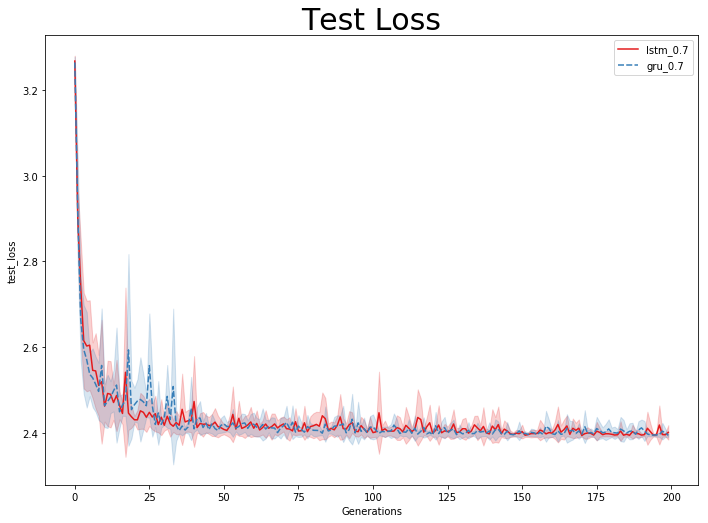

In [123]:
plot_metric(arch_dict, metric='test_loss')

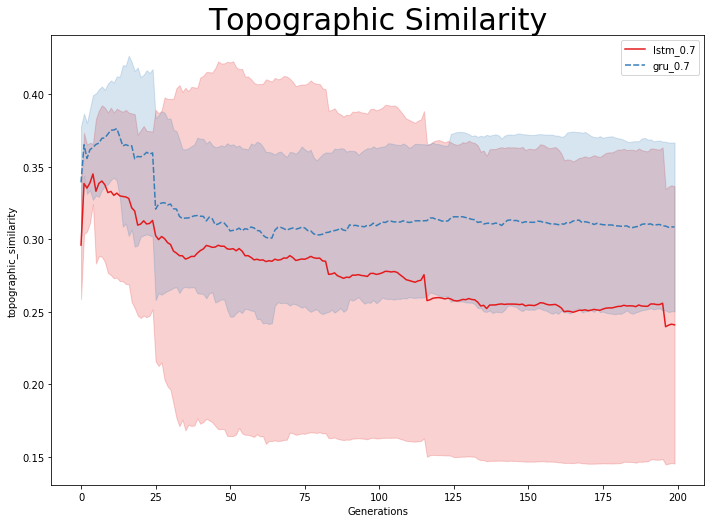

In [124]:
plot_metric(arch_dict, metric='topographic_similarity') #hamming / hamming

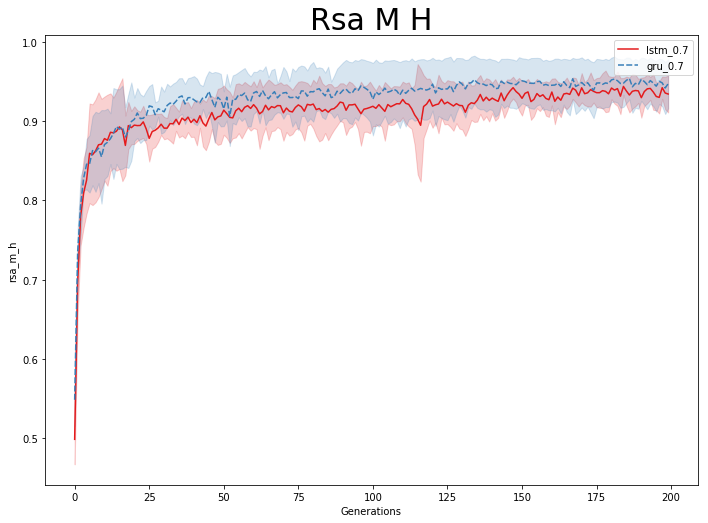

In [126]:
plot_metric(arch_dict, metric='rsa_m_h') # hamming / cosine

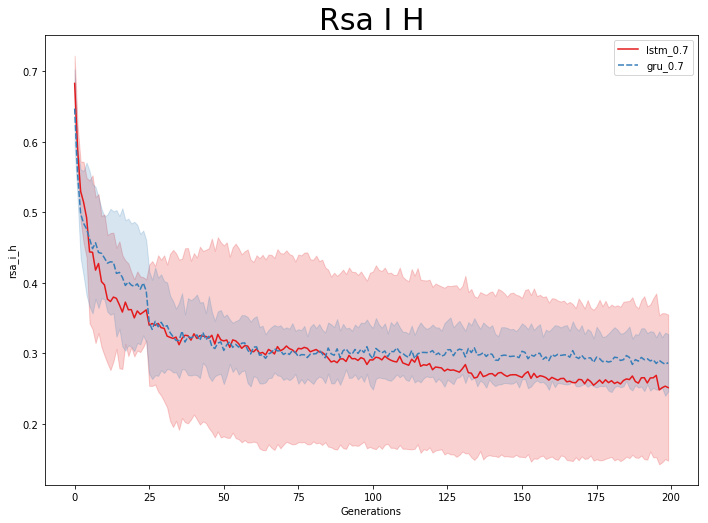

In [127]:
plot_metric(arch_dict, metric='rsa_i_h') # hamming / cosine

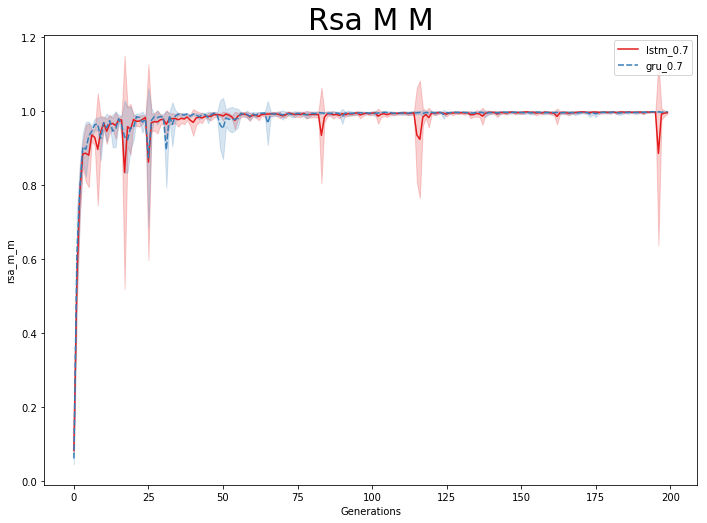

In [128]:
plot_metric(arch_dict, metric='rsa_m_m')  # hamming / hamming

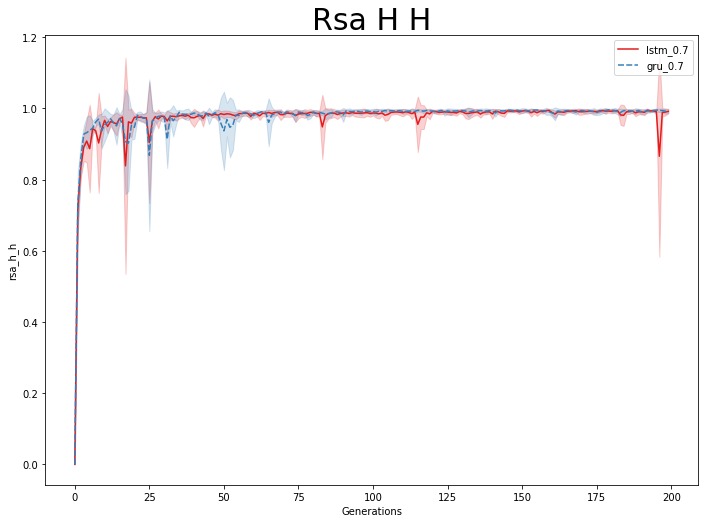

In [129]:
plot_metric(arch_dict, metric='rsa_h_h')  # hamming / hamming

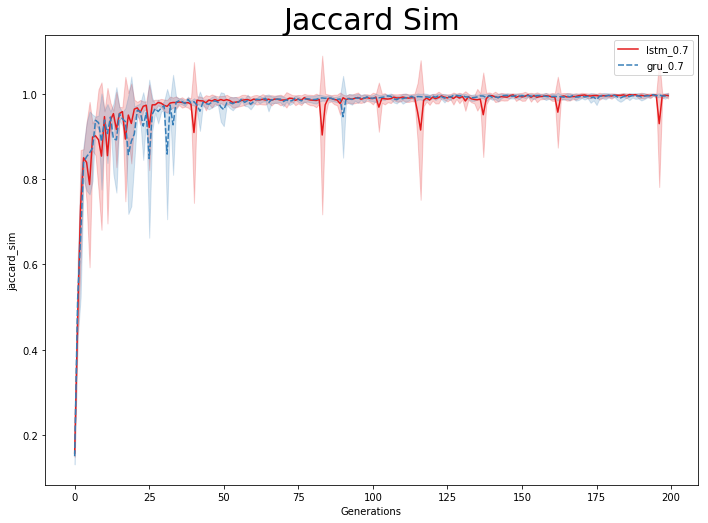

In [130]:
plot_metric(arch_dict, metric='jaccard_sim')

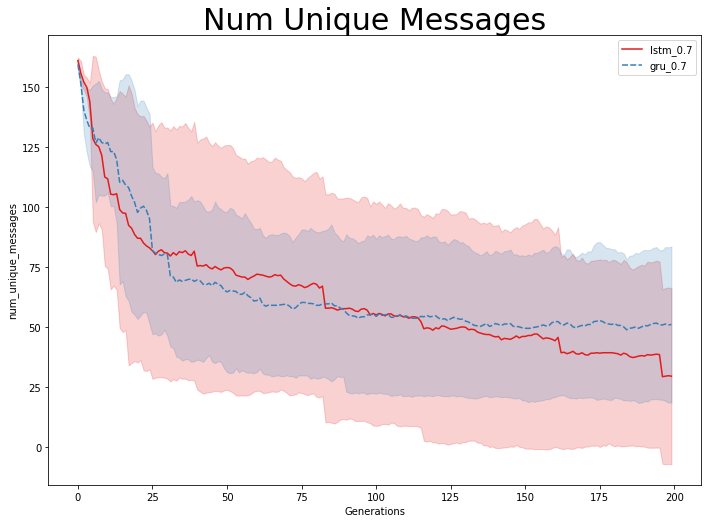

In [131]:
plot_metric(arch_dict, metric='num_unique_messages')

In [132]:
cross_seed_arch_metrics = {}
possible_runs = glob.glob("runs/*0.7/")
for r in possible_runs:
    run_name = get_run_name(r.split('/')[1])
    cross_seed_arch_metrics[run_name] = {}
    possible_seeds = glob.glob(r+'*')
    combinations = list(itertools.combinations(possible_seeds, 2))
    for p in combinations:
        seed_combination = p[0].split('/')[-1]+p[1].split('/')[-1]
        cross_seed_arch_metrics[run_name][seed_combination] = {}
        for i in range(200):
            cross_seed_arch_metrics[run_name][seed_combination][i] = {}
            hidden_filename = '/hidden_states_at_'+str(i)+'_sim.npy'
            language_filename = '/language_at_'+str(i)+'_sim.npy'
            rsa_h_h = get_correlation(p, hidden_filename)
            rsa_m_m = get_correlation(p, language_filename)

            cross_seed_arch_metrics[run_name][seed_combination][i]['rsa_h_h'] = rsa_h_h
            cross_seed_arch_metrics[run_name][seed_combination][i]['rsa_m_m'] = rsa_m_m

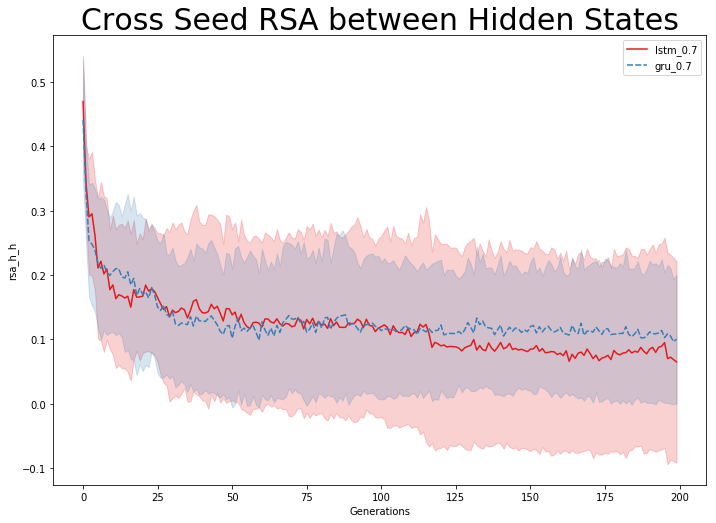

In [133]:
plot_metric(cross_seed_arch_metrics, metric='rsa_h_h', title='Cross Seed RSA between Hidden States')

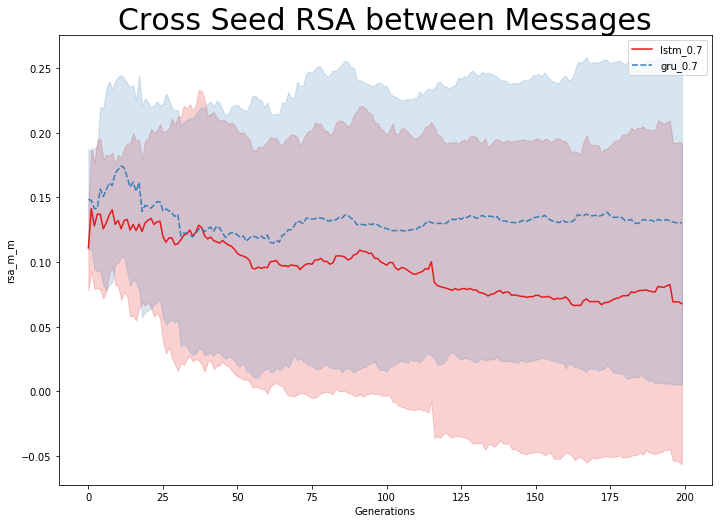

In [135]:
plot_metric(cross_seed_arch_metrics, metric='rsa_m_m', title='Cross Seed RSA between Messages')